# DAT 402 Project 2

# Plant Disease Detection from Leaf Images

---

### Team Members:
- Pete VanBenthuysen
- Emily Szolnoki
---

### Project Goal:
The goal of this project is to predict whether a plant — specifically bell pepper, potato, or tomato — is healthy or afflicted by a specific disease based on an image of its leaf.
Rather than simply detecting the presence of disease, the model is designed to identify the exact type of illness, enabling farmers to make informed decisions about whether a plant is salvageable, treatable, or needs to be removed.

This project leverages deep learning to create a rapid, low-cost diagnostic tool for agriculture.
Early and accurate detection of plant diseases in these critical crops is essential for preventing crop loss, maintaining food supply chains, and promoting sustainable farming practices.

Traditional methods of diagnosing plant diseases can be slow, require expert knowledge, and are often inaccessible to farmers in rural or resource-limited settings.
By training a convolutional neural network (CNN) on a large dataset of real-world agricultural images, we aim to automate disease identification across a wide range of conditions with high accuracy.

This project demonstrates how machine learning can transform agriculture by making expert-level diagnostics accessible to everyone — helping farmers make faster, more informed decisions, reduce unnecessary pesticide use, improve crop yields, and enhance global food security.
It also opens pathways for building mobile applications or embedded systems that bring AI-powered diagnostics directly into the hands of agricultural workers worldwide.

---

### Dataset:
We are using the "PlantVillage" dataset, sourced from Kaggle.  
The dataset contains over 20,000 labeled images of plant leaves, specifically focusing on three crops: bell peppers, potatoes, and tomatoes.
Each image is classified into one of 15 categories, representing either a specific disease or a healthy leaf.
The dataset is organized into folders based on the class label, with each folder containing images for a particular disease or healthy condition.
There are no missing values.
However, the distribution of images across classes is imbalanced, with certain diseases (such as Tomato Yellow Leaf Curl Virus) having significantly more samples than others (such as Potato healthy).

You can download the dataset [Here.](https://www.kaggle.com/datasets/emmarex/plantdisease)

After downloading, extract the contents into the `data/` folder of the project, preserving the folder structure.

In [1]:
import sys
import os
from pathlib import Path

src_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
print(f"src_path: {src_path}")
print(f"sys.path: {sys.path}")

if src_path not in sys.path:
    sys.path.insert(0, src_path)
    print(f"Added {src_path} to sys.path")

import config
print(config.__file__)  # This will show the path of the imported config.py
print(config.DATA_DIR)  # This should print the DATA_DIR path

src_path: c:\Users\petev\OneDrive\Desktop\Leaf Lens\plant-disease-detection\src
sys.path: ['C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\\python310.zip', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\\DLLs', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\\lib', 'C:\\Users\\petev\\AppData\\Local\\Microsoft\\WindowsApps\\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0', 'c:\\Users\\petev\\OneDrive\\Desktop\\Leaf Lens\\plant-disease-detection\\venv', '', 'c:\\Users\\petev\\OneDrive\\Desktop\\Leaf Lens\\plant-disease-detection\\venv\\lib\\site-packages', 'c:\\Users\\petev\\OneDrive\\Desktop\\Leaf Lens\\plant-disease-detection\\venv\\lib\\site-packages\\win32', 'c:\\Users\\petev\\OneDrive\\Desktop\\Leaf Lens\\plant-disease-detection\\venv\\lib\\site-packages\\win32\\lib', 'c:\\Users\\petev\\OneDrive\\Desktop\\Leaf Lens\\plant-

In [2]:
# Basic libraries
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data manipulation libraries
import shutil

# Image processing
from PIL import Image

# Machine learning libraries
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Deep learning libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)


Using device: cpu


Imports and Setup:
We start by importing all necessary libraries for data handling, visualization, machine learning, and deep learning.
We also check if a GPU is available to speed up training.

Setting Random Seeds:
To ensure reproducibility across multiple runs, random seeds are set for `torch`, `numpy`, and `random` early in the project.  
This controls random processes such as data splitting, model initialization, and sampling. This helps ensure consistent and comparable results across experiments. [1] 

[1] [PyTorch Reproducibility Guide](https://pytorch.org/docs/stable/notes/randomness.html)

In [3]:
# Define the path to the main PlantVillage folder
base_path = os.path.abspath(os.path.join(os.getcwd(), "..", "data", "PlantVillage"))

# Define the path to the duplicate PlantVillage folder
duplicate_path = os.path.join(base_path, "PlantVillage")

# Check if the duplicate folder exists
if os.path.exists(duplicate_path):
    print(f"Duplicate folder found at: {duplicate_path}")
    # Remove the duplicate folder and its contents
    shutil.rmtree(duplicate_path)
    print(f"Duplicate folder removed: {duplicate_path}")
else:
    print(f"No duplicate folder found at: {duplicate_path}")

No duplicate folder found at: c:\Users\petev\OneDrive\Desktop\Leaf Lens\plant-disease-detection\data\PlantVillage\PlantVillage


This code was implemented to address the issue of duplicate data in the PlantVillage dataset. Specifically, there was a nested `PlantVillage` folder inside the main `PlantVillage` directory, which contained duplicate data. This duplication could lead to:

- Data Redundancy: The same images being processed multiple times, which could skew the results of the analysis or model training.
- Increased Storage Usage: Unnecessary duplication of files increases storage requirements.
- Performance Issues: Processing duplicate data could slow down the pipeline and introduce inefficiencies.

The code ensures that the nested duplicate folder is identified and removed, leaving only the main `PlantVillage` folder with its subfolders intact.


Number of categories (classes): 15
Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
Skipped invalid image C:\Users\petev\OneDrive\Desktop\Leaf Lens\plant-disease-detection\data\PlantVillage\Tomato__Tomato_YellowLeaf__Curl_Virus\svn-r6Yb5c under category 'Tomato__Tomato_YellowLeaf__Curl_Virus': cannot identify image file 'C:\\Users\\petev\\OneDrive\\Desktop\\Leaf Lens\\plant-disease-detection\\data\\PlantVillage\\Tomato__Tomato_YellowLeaf__Curl_Virus\\svn-r6Yb5c'

Total images loaded: 20638
Each image shape: (128, 128, 3) (Height x Width x Channels)
Labels shape: (20638,)

--- Skipped Images Summary ---
Category 'Pepper__bell

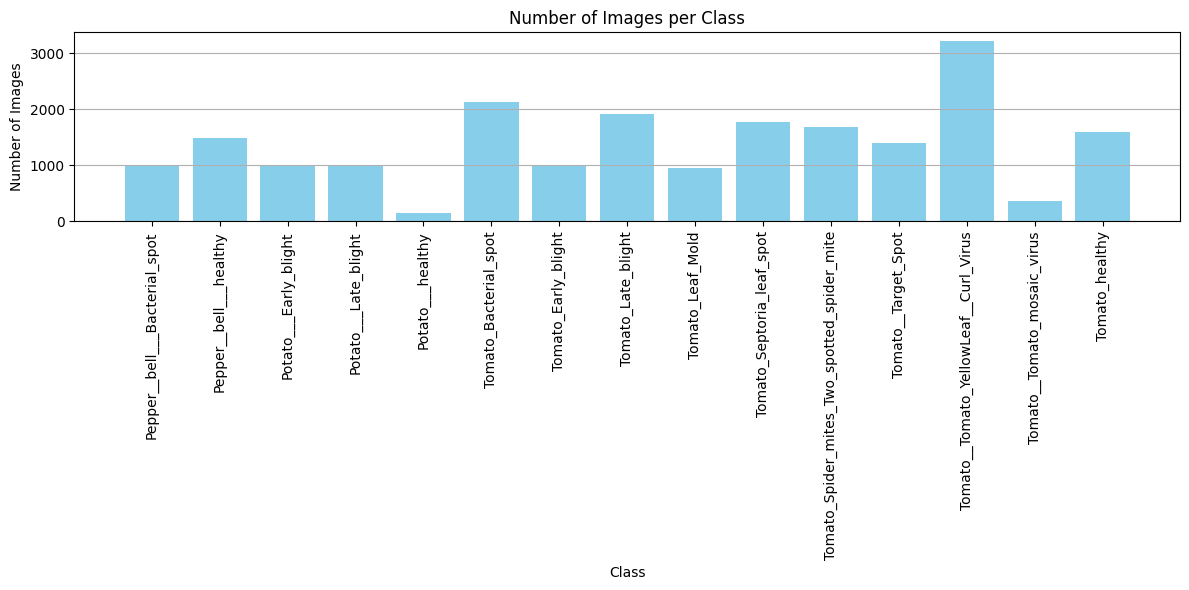


--- Observations ---
The dataset covers 15 different plant disease and healthy categories, primarily across bell peppers, potatoes, and tomatoes.
Images are consistently resized to 128x128 pixels with 3 color channels (RGB).


In [4]:
# Import the DATA_DIR from the config.py file
from config import DATA_DIR

# Path to the PlantVillage folder
plant_village_path = DATA_DIR / "PlantVillage"

# List categories (subfolders inside PlantVillage)
categories = sorted([folder.name for folder in plant_village_path.iterdir() if folder.is_dir()])
print(f"Number of categories (classes): {len(categories)}")
print("Classes:", categories)

# Load images and labels
images = []
labels = []
skipped_images = {}  # Dictionary to track skipped images per category

for label_idx, category in enumerate(categories):
    category_path = plant_village_path / category  # Path to the subfolder
    skipped_images[category] = 0  # Initialize skipped count for this category
    for img_name in os.listdir(category_path):  # Iterate over files in the subfolder
        img_path = category_path / img_name  # Full path to the image
        if img_path.is_file():  # Ensure it's a file (not a directory)
            try:
                img = Image.open(img_path).convert('RGB')  # Open the image
                img = img.resize((128, 128))  # Resize to a consistent shape
                img_array = np.array(img)  # Convert to a NumPy array
                images.append(img_array)  # Add the image to the list
                labels.append(label_idx)  # Add the corresponding label
            except (IOError, OSError) as e:
                print(f"Skipped invalid image {img_path} under category '{category}': {e}")
                skipped_images[category] += 1  # Increment skipped count for this category

images = np.array(images)
labels = np.array(labels)

# Print basic dataset characteristics
print(f"\nTotal images loaded: {images.shape[0]}")
print(f"Each image shape: {images.shape[1:]} (Height x Width x Channels)")
print(f"Labels shape: {labels.shape}")

# Print skipped images summary
print("\n--- Skipped Images Summary ---")
for category, count in skipped_images.items():
    print(f"Category '{category}': {count} images skipped")

# Plot a bar chart of class distribution
labels_df = pd.DataFrame({'label': labels})
class_counts = labels_df['label'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.bar(range(len(categories)), class_counts.values, tick_label=categories, color='skyblue')
plt.xticks(rotation=90)
plt.title('Number of Images per Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Print observations
print("\n--- Observations ---")
print(f"The dataset covers {len(categories)} different plant disease and healthy categories, primarily across bell peppers, potatoes, and tomatoes.")
print("Images are consistently resized to 128x128 pixels with 3 color channels (RGB).")

## Dataset Description

The PlantVillage dataset is organized into 15 distinct classes, with each class represented as a subfolder under the `PlantVillage` directory.  
Each subfolder corresponds to a specific plant disease or a healthy plant condition across bell peppers, potatoes, and tomatoes.

### Data Loading and Cleaning Steps

- For each class, all files within its subfolder were iterated.
- Only valid image files (non-directories) were processed.
- Images were opened with the Pillow (PIL) library, converted to RGB, and resized to 128×128 pixels. [2]
- Invalid or unreadable files (e.g., corrupted or non-image files) were safely skipped without interrupting the loading process.
- Skipped images were tracked per category for auditing purposes.

### Dataset Characteristics

- Total of 20,638 valid images successfully loaded.
- Each image is a NumPy array of shape (128, 128, 3).
- Labels were assigned as integer IDs (0–14) based on the alphabetical order of class names.

### Observations

- The dataset exhibits a class imbalance, with diseases like *Tomato Yellow Leaf Curl Virus* overrepresented compared to others like *Potato Healthy*. 
- Addressing class imbalance during model training (e.g., through data augmentation or class-weighted loss) is important to prevent bias.
- The dataset is rich, diverse, and well-structured, providing a strong foundation for developing machine learning models, particularly Convolutional Neural Networks (CNNs) for image classification tasks.

[2] [Pillow documentation](https://realpython.com/image-processing-with-the-python-pillow-library/)


--- Potato Dataset ---
Healthy: 152 images
Infected (Potato___Early_blight): 1000 images
Infected (Potato___Late_blight): 1000 images


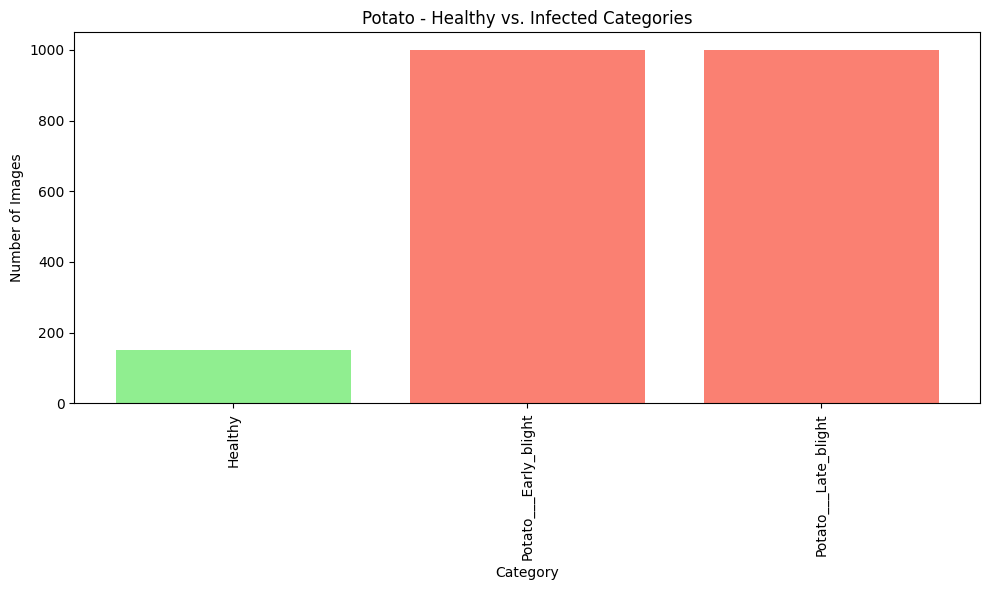


--- Pepper Dataset ---
Healthy: 1478 images
Infected (Pepper__bell___Bacterial_spot): 997 images


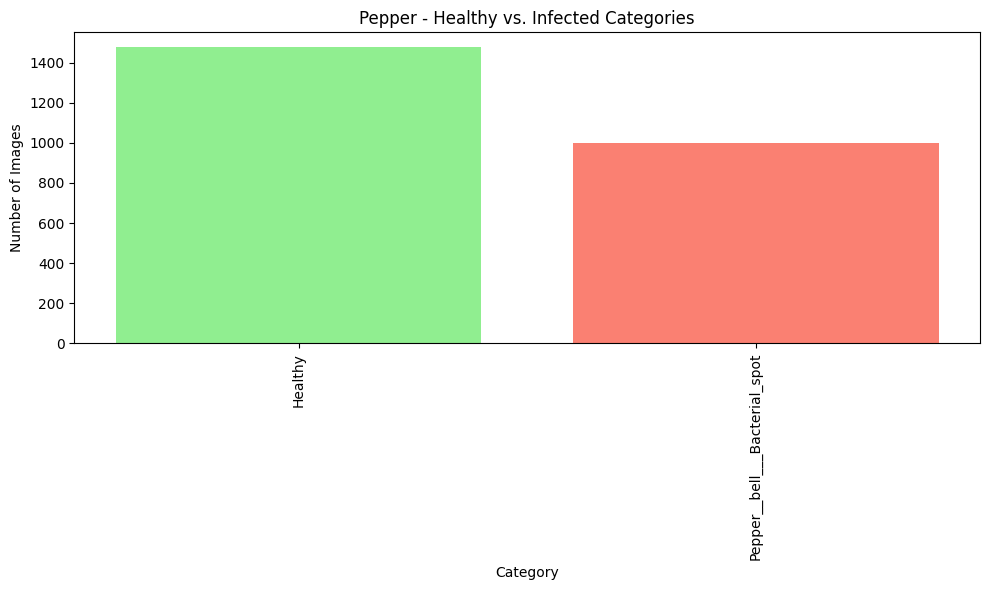


--- Tomato Dataset ---
Healthy: 1591 images
Infected (Tomato_Bacterial_spot): 2127 images
Infected (Tomato_Early_blight): 1000 images
Infected (Tomato_Late_blight): 1909 images
Infected (Tomato_Leaf_Mold): 952 images
Infected (Tomato_Septoria_leaf_spot): 1771 images
Infected (Tomato_Spider_mites_Two_spotted_spider_mite): 1676 images
Infected (Tomato__Target_Spot): 1404 images
Infected (Tomato__Tomato_YellowLeaf__Curl_Virus): 3208 images
Infected (Tomato__Tomato_mosaic_virus): 373 images


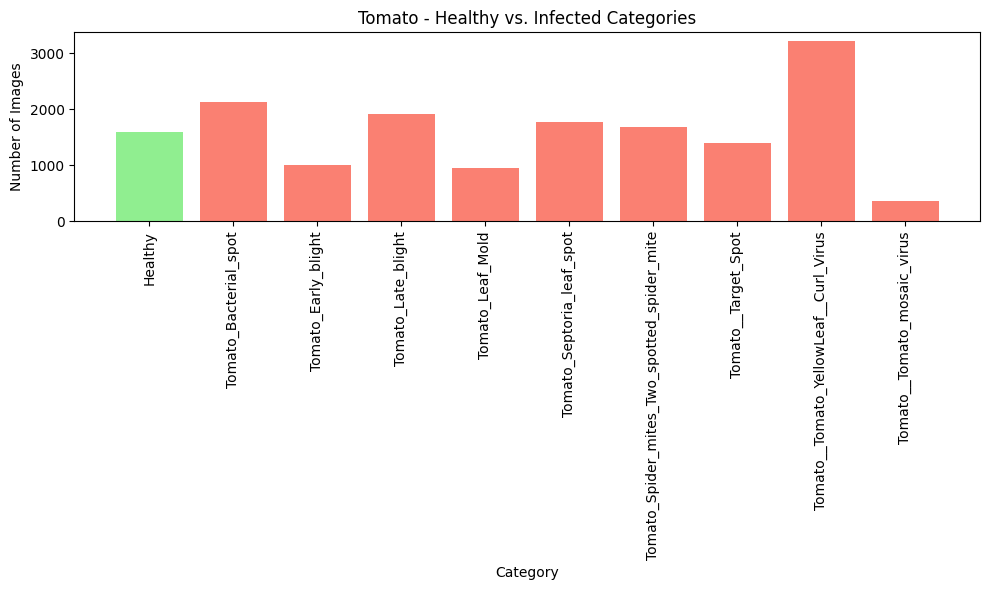

In [5]:
# Bar chart of class distribution
# Group categories into healthy and infected for each crop
crops = {
    "Potato": {"healthy": 0, "infected": {}},
    "Pepper": {"healthy": 0, "infected": {}},
    "Tomato": {"healthy": 0, "infected": {}}
}

# Map numeric indices in class_counts to category names
for label_idx, count in class_counts.items():
    category = categories[label_idx]  # Get the category name from the index
    if "Potato" in category:
        if "healthy" in category.lower():
            crops["Potato"]["healthy"] += count
        else:
            crops["Potato"]["infected"][category] = count
    elif "Pepper" in category:
        if "healthy" in category.lower():
            crops["Pepper"]["healthy"] += count
        else:
            crops["Pepper"]["infected"][category] = count
    elif "Tomato" in category:
        if "healthy" in category.lower():
            crops["Tomato"]["healthy"] += count
        else:
            crops["Tomato"]["infected"][category] = count

# Function to plot bar chart for a specific crop
def plot_crop_distribution(crop_name, crop_data):
    labels = ["Healthy"] + list(crop_data["infected"].keys())
    counts = [crop_data["healthy"]] + list(crop_data["infected"].values())

    plt.figure(figsize=(10, 6))
    plt.bar(labels, counts, color=["lightgreen"] + ["salmon"] * len(crop_data["infected"]))
    plt.xticks(rotation=90)
    plt.title(f"{crop_name} - Healthy vs. Infected Categories")
    plt.xlabel("Category")
    plt.ylabel("Number of Images")
    plt.tight_layout()
    plt.show()

# Plot bar charts for each crop
for crop_name, crop_data in crops.items():
    print(f"\n--- {crop_name} Dataset ---")
    print(f"Healthy: {crop_data['healthy']} images")
    for category, count in crop_data["infected"].items():
        print(f"Infected ({category}): {count} images")
    plot_crop_distribution(crop_name, crop_data)

Across the datasets, a notable class imbalance between healthy and infected samples exists.
Potato shows a severe shortage of healthy samples (152 vs 2000 infected), while Pepper is more balanced.
Tomato is strongly dominated by infected samples, with several disease classes individually surpassing the number of healthy images.
Such imbalances must be considered carefully during model development to avoid biased learning outcomes.

Number of images: 20638
Number of labels: 20638
New shape after flattening: (20638, 49152)
Shape after PCA: (20638, 2)


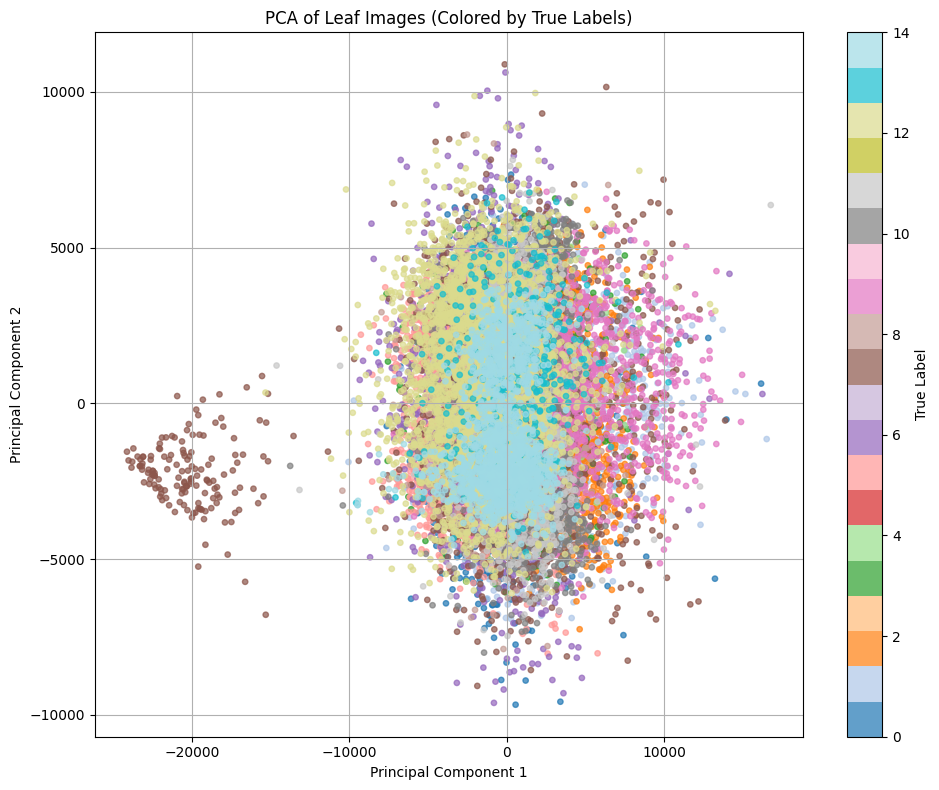

Cluster assignments shape: (20638,)


In [ ]:
# Debugging: Check the number of images and labels
print(f"Number of images: {images.shape[0]}")
print(f"Number of labels: {len(labels)}")

# Ensure the number of labels matches the number of images
assert len(labels) == images.shape[0], "Mismatch between the number of images and labels!"

# Flatten the images: (n_samples, 128, 128, 3) → (n_samples, 128*128*3)
X_flat = images.reshape(images.shape[0], -1)

print(f"New shape after flattening: {X_flat.shape}")

# Reduce to 2 principal components for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_flat)

print(f"Shape after PCA: {X_pca.shape}")

# Ensure labels are numeric and match the dataset size
# If labels are not numeric, map them to integers
unique_labels = np.unique(labels)
label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
numeric_labels = np.array([label_to_int[label] for label in labels])  # Map each label to its numeric value

# Check that numeric_labels matches the number of rows in X_pca
assert len(numeric_labels) == X_pca.shape[0], "Mismatch between labels and data points."

# Scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=numeric_labels, cmap='tab20', alpha=0.7, s=15)
plt.colorbar(scatter, label='True Label')
plt.title('PCA of Leaf Images (Colored by True Labels)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.tight_layout()
plt.show()

# Perform KMeans clustering on the PCA-reduced data
kmeans = KMeans(n_clusters=15, random_state=42)
clusters = kmeans.fit_predict(X_pca)

print(f"Cluster assignments shape: {clusters.shape}")

### PCA Visualization Analysis

After flattening the leaf images and applying Principal Component Analysis (PCA) to reduce the dimensionality, we visualized the resulting principal components in a 2D scatter plot.  
Each point in the plot represents an individual leaf image, positioned based on its major sources of pixel variance captured by PCA.

#### Dataset and Processing Overview:
- Number of images: 20,638
- Number of labels: 20,638
- Flattened feature size: 49,152 features per image (128×128×3)
- PCA reduced shape: (20,638, 2) (two principal components per image)
- Cluster assignments shape (after K-Means): (20,638,)

The scatter plot reveals that while some classes form partially distinct clusters, there is significant overlap among most categories.  
This overlap indicates that raw pixel intensity patterns alone are not sufficient for clean separation of plant diseases, highlighting the limitations of pixel-level features.  
Such findings reinforce the importance of applying deeper feature extraction techniques, such as convolutional layers in CNNs, to learn more abstract and discriminative representations from images.

Interestingly, one distinct group of images appears isolated from the main distribution, suggesting that certain diseases—likely those with very unique visual symptoms—are more easily distinguishable even in low-dimensional pixel space.  
Overall, the PCA visualization provides valuable initial insights into the structure and complexity of the dataset, setting the stage for further analysis through clustering and supervised deep learning models.


In [7]:
from config import OUTPUTS_DIR

# Normalize images
images_normalized = images / 255.0  # Normalize pixel values to [0, 1]

# Split the dataset into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(images_normalized, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# --- Step 1: Save CNN splits ---
cnn_split_dir = Path(OUTPUTS_DIR) / "splits_cnn"
if not cnn_split_dir.exists():
    cnn_split_dir.mkdir(parents=True, exist_ok=True)

    def save_cnn_split(data, labels, split_name):
        split_dir = cnn_split_dir / split_name
        split_dir.mkdir(parents=True, exist_ok=True)
        for idx, (img, label) in enumerate(zip(data, labels)):
            category_dir = split_dir / f"class_{label}"  # Use class labels for folder names
            category_dir.mkdir(parents=True, exist_ok=True)
            img_path = category_dir / f"img_{idx}.png"
            Image.fromarray((img * 255).astype(np.uint8)).save(img_path)

    save_cnn_split(X_train, y_train, "train")
    save_cnn_split(X_val, y_val, "val")
    save_cnn_split(X_test, y_test, "test")
    print("CNN splits saved in outputs folder.")
else:
    print("CNN splits already exist. Skipping save.")

# --- Step 2: Prepare RF splits ---
rf_split_dir = Path(OUTPUTS_DIR) / "splits_rf"
if not rf_split_dir.exists():
    rf_split_dir.mkdir(parents=True, exist_ok=True)

    # Reuse the earlier PCA-transformed data
    X_train_pca = X_pca[:len(y_train)]  # Use the first len(y_train) rows
    X_val_pca = X_pca[len(y_train):len(y_train) + len(y_val)]  # Use the next len(y_val) rows

    # Save PCA-transformed train and validation sets
    np.save(rf_split_dir / "X_train_pca.npy", X_train_pca)
    np.save(rf_split_dir / "X_val_pca.npy", X_val_pca)
    np.save(rf_split_dir / "y_train.npy", y_train)
    np.save(rf_split_dir / "y_val.npy", y_val)

    # Save the original test set for RF
    np.save(rf_split_dir / "X_test.npy", X_test)
    np.save(rf_split_dir / "y_test.npy", y_test)
    print("RF splits saved in outputs folder.")
else:
    print("RF splits already exist. Skipping save.")

CNN splits saved in outputs folder.
RF splits saved in outputs folder.


This code prepares the dataset for both a Convolutional Neural Network (CNN) and a Random Forest (RF) model by performing data preprocessing, organizing splits, and saving the data in the appropriate format. By moving the data to the outputs folder, we are able to preserve the data used during our EDA.

### 1. Normalizing Image Data
The images are normalized by dividing the pixel values by 255. This step scales the pixel values into the range of [0, 1], ensuring all features have the same scale. Normalization helps improve model training efficiency and convergence, especially for neural networks like CNNs.

### 2. Splitting the Dataset
The dataset is split into training, validation, and test sets. First, 80% of the data is assigned to the training set, and the remaining 20% is split further into validation and test sets, each receiving 10% of the total dataset. This allows the model to train on one portion of the data, tune hyperparameters using the validation set, and evaluate its performance on the unseen test set.

### 3. Checking for Existing CNN Splits
Before saving the data for the CNN model, the script checks whether the CNN splits already exist in the output directory. If the splits do not exist, it creates a new directory and organizes the images into train, validation, and test folders, each categorized by class label (e.g., healthy or infected). This check prevents overwriting existing splits, ensuring the data is not processed unnecessarily if it's already available.

### 4. Saving CNN Data
Once the split directories are created, the images are saved as .png files inside their respective folders. The images are saved according to their class labels, such as class_0, class_1, etc., to make them ready for training with a CNN. The images are saved in the form of arrays with pixel values scaled back to the [0, 255] range for consistency.

### 5. Preparing RF Data with PCA
For the Random Forest (RF) model, the image data is flattened into one-dimensional arrays (vectors). PCA is then applied to reduce the dimensionality of the image data, retaining only the most important features. This is done exclusively on the training and validation sets to avoid data leakage. The test set remains untouched in its original form for final evaluation.

Once PCA is applied to the training and validation sets, the reduced features are saved in .npy files, which are more efficient for storing numerical data in Python. These transformed data arrays are saved along with the labels for the training and validation sets, making them ready for use with the Random Forest model.

### 6. Saving Test Data for RF
The original, non-PCA-transformed data for the test set is saved separately, as it will be used for the final evaluation of the model's performance. This ensures that the test data is not altered by any preprocessing steps (such as PCA) that are applied to the training and validation sets.

### 7. Overview
The code effectively splits the dataset while preserving the ability to identify the type of infection. Both the CNN and RF models will be able to classify images into their respective categories based on the preserved labels and folder structure.

In [8]:
# Define transformations for real-world scenarios (for CNN only)
transform = transforms.Compose([
    transforms.RandomRotation(degrees=30),  # Randomly rotate images by ±30 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust brightness, contrast, etc.
    transforms.RandomResizedCrop(size=(128, 128), scale=(0.8, 1.0)),  # Randomly crop and resize
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally
    transforms.ToTensor()  # Convert image to tensor
])

# Function to clear existing folders
def clear_folder(folder_path):
    folder_path = Path(folder_path)
    if folder_path.exists():
        shutil.rmtree(folder_path)  # Delete the folder and its contents
    folder_path.mkdir(parents=True, exist_ok=True)  # Recreate the empty folder

# Function to apply transformations and save augmented images (for CNN only)
def apply_transformations_and_save(data, labels, output_dir):
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    for idx, (img_array, label) in enumerate(zip(data, labels)):
        img = Image.fromarray((img_array * 255).astype(np.uint8))  # Convert back to PIL image
        transformed_img = transform(img)  # Apply transformations
        transformed_img = transforms.ToPILImage()(transformed_img)  # Convert back to PIL for saving
        
        # Save the transformed image
        class_dir = output_dir / f"class_{label}"
        class_dir.mkdir(parents=True, exist_ok=True)
        transformed_img.save(class_dir / f"img_{idx}_transformed.png")  # Add '_transformed' to the filename

# --- Check if transformed CNN folders already exist ---
cnn_train_dir_transformed = Path(OUTPUTS_DIR) / "splits_cnn_transformed" / "train"
cnn_val_dir_transformed = Path(OUTPUTS_DIR) / "splits_cnn_transformed" / "val"

if not cnn_train_dir_transformed.exists() or not cnn_val_dir_transformed.exists():
    # Clear and apply transformations if folders don't exist
    clear_folder(cnn_train_dir_transformed)
    clear_folder(cnn_val_dir_transformed)
    apply_transformations_and_save(X_train, y_train, cnn_train_dir_transformed)
    apply_transformations_and_save(X_val, y_val, cnn_val_dir_transformed)
    print("Transformed CNN training and validation data saved.")
else:
    print("Transformed CNN data already exists. Skipping transformation.")

# --- Keep RF data as is ---
# No transformations are applied to RF data
print("RF data remains unchanged.")

Transformed CNN training and validation data saved.
RF data remains unchanged.


This code applies data augmentation specifically to the CNN dataset splits by creating new, transformed versions of the training and validation images. It is intended to improve model generalization by simulating real-world variability in the leaf images, such as changes in rotation, lighting, cropping, and orientation.

First, a transformation pipeline is defined using torchvision.transforms.Compose. The pipeline randomly rotates images by ±30 degrees, applies random color jitter to adjust brightness, contrast, saturation, and hue, randomly resizes and crops images to 128x128 pixels, randomly flips images horizontally with a probability of 50%, and finally converts the augmented image to a tensor format. [3] [4]

The code then defines a function to clear an existing folder if it already exists and recreate it as an empty folder. This ensures that old, outdated augmented images are deleted before new ones are generated.

A second function is defined to apply the transformations to each image and save the newly transformed versions into a new output directory. Each image is augmented individually, and the augmented images are saved under their respective class folders, with filenames labeled to indicate that they are transformed versions.

Next, the script checks whether the output folders for the transformed training and validation datasets already exist. If they do not exist, the code clears or creates the appropriate folders and applies the transformations to the training and validation datasets. If the folders already exist, it skips the transformation process to avoid redundant computation.

The training and validation datasets for the CNN will now come from the splits_cnn_transformed directory, where the images have been augmented. However, the test set images will continue to come from the original splits_cnn directory without any augmentation. This ensures that the model is evaluated on completely unaltered, real-world test images, maintaining a fair evaluation standard.

Meanwhile, the Random Forest (RF) dataset remains completely unchanged. No transformations or augmentations are applied to the RF data, as Random Forests are trained on flattened, non-image arrays where spatial information and visual transformations are not relevant.

In summary, this code ensures that the CNN model benefits from additional variability and robustness during training, while the RF model and the CNN test evaluation remain based on the original unaltered data. This careful separation of augmented and original data helps maintain training integrity while improving generalization.

[3] [Fine Tuning Transforms](https://rumn.medium.com/ultimate-guide-to-fine-tuning-in-pytorch-part-3-deep-dive-to-pytorch-data-transforms-53ed29d18dde)
[4] [Transforming and Augmenting Images](https://rumn.medium.com/ultimate-guide-to-fine-tuning-in-pytorch-part-3-deep-dive-to-pytorch-data-transforms-53ed29d18dde)